In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import KF1
import KF2
import KF_Paper
import KF_PaperUni

# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times p)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)


# Dummy data for the KF with non time-varying parameters

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

# Dummy data

In [2]:
# PARAMETERS
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1.0,2.0,3.0,4.0]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

# GENERATE DATA

n = 10000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

# GENERATE PARTIAL NULL

nny = y.copy()
probNan= 0.70
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan
    
    
# GENERATE WHOLE NULL

wny = y.copy()
probNan= 0.50
for i in wny.index:
    ran = np.random.uniform(size=(1))
    if ran < probNan:
        wny.iloc[i] = np.nan


In [3]:
y = np.array(y)
nny = np.array(nny)
wny = np.array(wny)
Z = np.array(Z)
H = np.array(H)
T = np.array(T)
R = np.array(R)
Q = np.array(Q)

#a1 = (m x 1)
a1 = np.zeros(m)
#P1 = (m x m)
P1 = np.diag(np.ones(m)*1.0)

# Testing the KFs

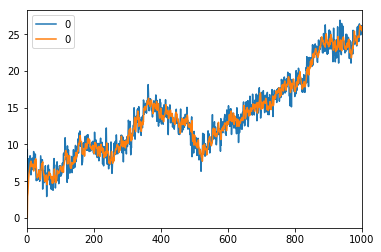

In [4]:
ret = KF2.KalmanFilter(
    y = y,
#     y = wny,
#     y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


In [5]:
ret.shape

(1001, 4)

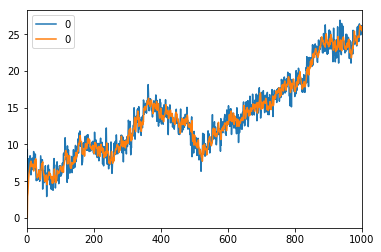

In [6]:
ret = KF1.KalmanFilter(
    y = y,
#     y = wny,
#     y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

vy = pd.DataFrame(y)

i = 0

pd.concat([vy[i], ret[i]], axis=1).plot()


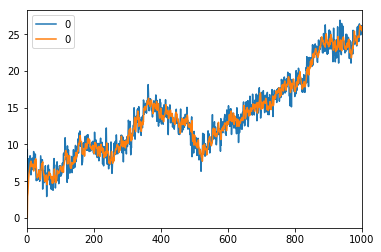

In [7]:
ret = KF_PaperUni.KalmanFilter(
    y = y,
#     y = wny,
#     y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0],
    export=True
)

vy = pd.DataFrame(y)

i = 0

ret = ret['yhat']

pd.concat([vy[i], ret[i]], axis=1).plot()

# Performance

In [8]:
%%timeit

ret = KF_Paper.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0]
)

10 loops, best of 3: 111 ms per loop


In [9]:
%%timeit

ret = KF_PaperUni.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
    nStates = a1.shape[0],
    export=True
)

10 loops, best of 3: 98.2 ms per loop


In [10]:
%%timeit

ret = KF1.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

10 loops, best of 3: 137 ms per loop


In [11]:
%%timeit

ret = KF2.KalmanFilter(
#     y = y,
#     y = wny,
    y = nny,
    Z = Z,
    H = H,
    T = T,
    R = R,
    Q = Q,
    a1 = a1,
    P1 = P1,
)

10 loops, best of 3: 147 ms per loop


In [13]:
v1 = np.random.rand(2,2)
v2 = np.random.rand(2,2)

In [17]:
%%timeit 

v1.dot(v2.dot(v1.dot(v2)))

The slowest run took 9.01 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.14 µs per loop


In [18]:
%%timeit

np.linalg.multi_dot([v1,v2,v1,v2])

The slowest run took 4.67 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 32.9 µs per loop
